In [2]:
### 导入模块
import datetime
from datetime import datetime
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
import folium
import lightgbm as lgb
from folium.plugins import HeatMap
from keras.models import Sequential
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew 
import plotly_express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为50
pd.set_option('max_colwidth',50)

Using TensorFlow backend.


In [3]:
# 载入数据
df = pd.read_excel('data.xlsx',encoding='gbk',sheetname=4)
df0 = pd.read_excel('data.xlsx',encoding='gbk',sheetname=0)
df1 = pd.read_excel('data.xlsx',encoding='gbk',sheetname=1)
df2 = pd.read_excel('data.xlsx',encoding='gbk',sheetname=2)
df3 = pd.read_excel('data.xlsx',encoding='gbk',sheetname=3)
# 数据合并
dff = pd.concat([df0,df1,df2,df3])
# 数据预处理
dff["tube_name"] = dff["city"] + dff["tube_name"]
dff.drop(labels=['city'],axis=1,inplace=True)
# 数据合并
data = pd.merge(df,dff,on="tube_name")
                
data.rename(columns={'租金中位数（元/月）':'area_price_level', '居住便利度':'convenience', 'tube_distance（m）':'tube_distance'},inplace = True)

In [4]:
data['city_cn']=data['city']
data.city[data.city=='上海'] = 'shanghai'
data.city[data.city=='广州'] = 'guangzhou'
data.city[data.city=='北京'] = 'beijing'
data.city[data.city=='深圳'] = 'shenzhen'

In [5]:
# 对类别特征编码
lb=LabelEncoder()
data['city_encode'] = lb.fit_transform(data['city'].values)
data['floor_encode'] = lb.fit_transform(data['floor'].values)
data['towards_encode'] = lb.fit_transform(data['towards'].values)

In [6]:
data.head(3)

,ID,city,floor,rent_room,towards,latitude,longitude,price_area,room_no,tube_distance,tube_name,area_price_level,convenience,city_cn,city_encode,floor_encode,towards_encode
0,29,shanghai,低楼层,5000.000000,南,31.239668,121.471921,151.515152,2,659.543339,上海人民广场,8666.666667,93.985965,上海,2,1,22
1,22614,shanghai,低楼层,3600.000000,南,31.231730,121.468079,180.000000,1,481.771180,上海人民广场,8666.666667,93.985965,上海,2,1,22
2,22619,shanghai,中楼层,4833.333333,南,31.238967,121.470462,105.839416,3,552.412127,上海人民广场,8666.666667,93.985965,上海,2,0,22


## 数据可视化

In [9]:
test=data[(data.rent_room<=1000)&(data.price_area>=70)]

drop1=[x for i,x in enumerate(data.index) if (data['rent_room'].iloc[i]<=1000)&(data['price_area'].iloc[i]>=60)]

data=data.drop(drop1,axis=0) 

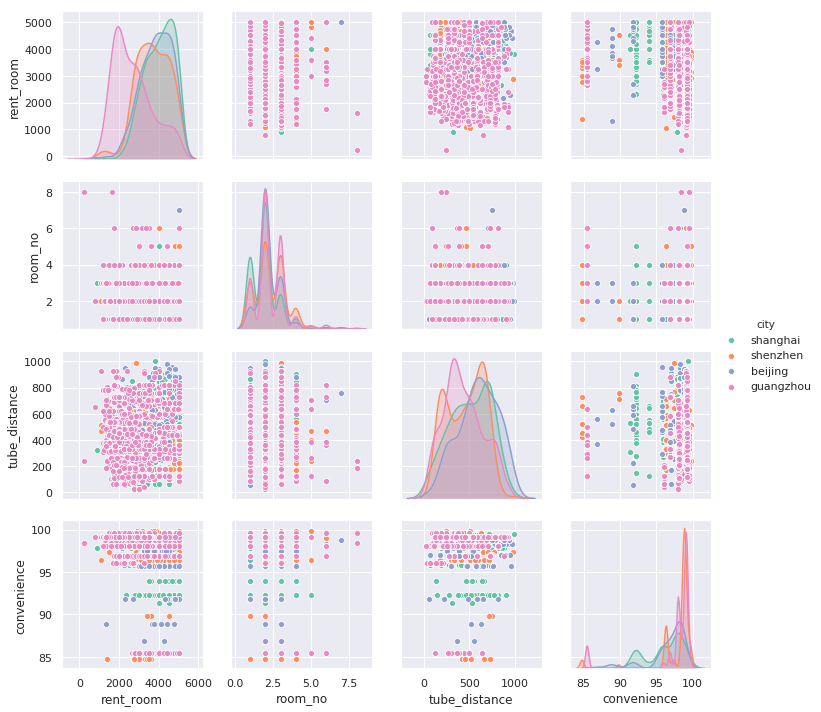

In [10]:
p = sns.pairplot(pd.DataFrame(list(zip(data['rent_room'], data['city'], data['room_no'], data['tube_distance'], data['convenience'])), 
                        columns=['rent_room','city', 'room_no', 'tube_distance', 'convenience']), hue='city', palette="Set2")

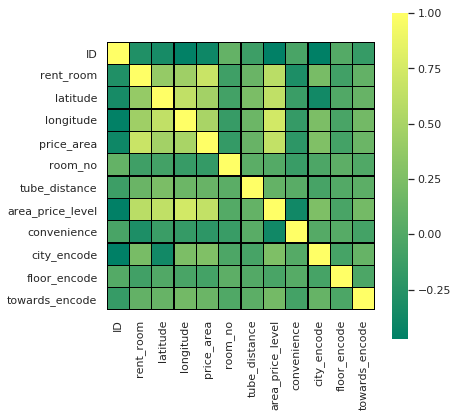

In [11]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr(),linewidths=0.1,linecolor='black',square=True,cmap='summer')

In [13]:
shanghai=data[data.city=='shanghai']
beijing=data[data.city=='beijing']
shenzhen=data[data.city=='shenzhen']
guangzhou=data[data.city=='guangzhou']

guangdong=data[(data.city=='guangzhou')|(data.city=='shenzhen')]
guangdong = guangdong.groupby('tube_name').first()

print(len(shanghai))
print(len(beijing))
print(len(shenzhen))
print(len(guangzhou))
print(len(guangdong))

275
176
215
819
20


## LGBM

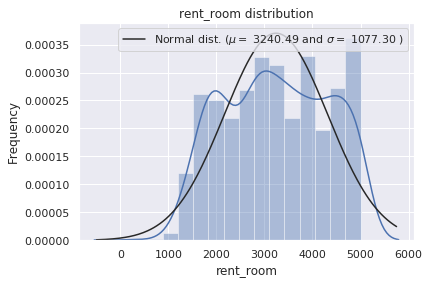

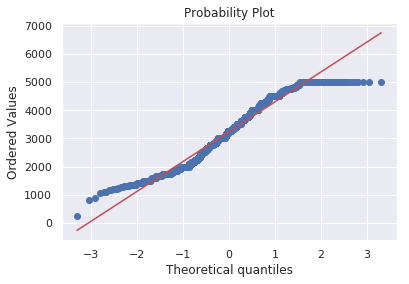

In [18]:
sns.distplot(data['rent_room'] , fit=norm);

(mu, sigma) = norm.fit(data['rent_room'])

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('rent_room distribution')

#Get QQ-plot
fig = plt.figure()
res = stats.probplot(data['rent_room'], plot=plt)
plt.show()


In [19]:
data.head()

,ID,city,floor,rent_room,towards,latitude,longitude,price_area,room_no,tube_distance,tube_name,area_price_level,convenience,city_cn,city_encode,floor_encode,towards_encode
0,29,shanghai,低楼层,5000.000000,南,31.239668,121.471921,151.515152,2,659.543339,上海人民广场,8666.666667,93.985965,上海,2,1,22
1,22614,shanghai,低楼层,3600.000000,南,31.231730,121.468079,180.000000,1,481.771180,上海人民广场,8666.666667,93.985965,上海,2,1,22
2,22619,shanghai,中楼层,4833.333333,南,31.238967,121.470462,105.839416,3,552.412127,上海人民广场,8666.666667,93.985965,上海,2,0,22
3,22936,shanghai,高楼层,4500.000000,南,31.233857,121.471158,121.621622,1,128.092605,上海人民广场,8666.666667,93.985965,上海,2,3,22
4,23431,shanghai,中楼层,4000.000000,南/北,31.238967,121.470462,118.518519,4,552.412127,上海人民广场,8666.666667,93.985965,上海,2,0,23


In [20]:
col=['price_area', 'tube_distance','convenience', 'floor_encode', 'latitude', 'longitude','towards_encode']

X=data[col]
y=data['rent_room']

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0,test_size=0.2)

In [21]:
# 导入到lightgbm矩阵
lgb_train = lgb.Dataset(X_train, y_train, feature_name=col, categorical_feature=['floor_encode'])
lgb_test = lgb.Dataset(X_test, y_test, feature_name=col, categorical_feature=['floor_encode'], reference=lgb_train)

# 设置参数
params = {'nthread': 4,  # 进程数
              'objective': 'regression',
              'learning_rate':0.001,
              #'num_leaves': 1024, 
              #'max_depth': 10, 
              'feature_fraction': 0.7,  # 样本列采样
              'lambda_l1':0.001,  # L1 正则化
              'lambda_l2': 0,  # L2 正则化
              'bagging_seed': 100,  # 随机种子
              }
params['metric'] = ['rmse']

evals_result = {}  #记录训练结果

print('开始训练...')
gbm_start=datetime.now() 
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=[lgb_train, lgb_test],
                evals_result=evals_result,
                verbose_eval=10)
gbm_end=datetime.now() 
print('spendt time :'+str((gbm_end-gbm_start).seconds)+'(s)')

开始训练...
[10]	training's rmse: 1085.61	valid_1's rmse: 1008.17
[20]	training's rmse: 1078.64	valid_1's rmse: 1002.13
[30]	training's rmse: 1071.49	valid_1's rmse: 995.997
[40]	training's rmse: 1064.86	valid_1's rmse: 990.316
[50]	training's rmse: 1058.37	valid_1's rmse: 984.721
[60]	training's rmse: 1051.88	valid_1's rmse: 979.19
[70]	training's rmse: 1045.35	valid_1's rmse: 973.648
[80]	training's rmse: 1039.04	valid_1's rmse: 968.343
[90]	training's rmse: 1032.69	valid_1's rmse: 962.978
[100]	training's rmse: 1026.24	valid_1's rmse: 957.554
[110]	training's rmse: 1019.93	valid_1's rmse: 952.173
[120]	training's rmse: 1014.01	valid_1's rmse: 947.258
[130]	training's rmse: 1008.07	valid_1's rmse: 942.277
[140]	training's rmse: 1002.05	valid_1's rmse: 937.287
[150]	training's rmse: 996.21	valid_1's rmse: 932.421
[160]	training's rmse: 990.698	valid_1's rmse: 927.901
[170]	training's rmse: 984.91	valid_1's rmse: 923.113
[180]	training's rmse: 978.936	valid_1's rmse: 918.2
[190]	training's

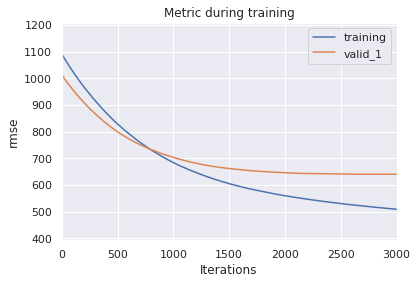

In [22]:
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

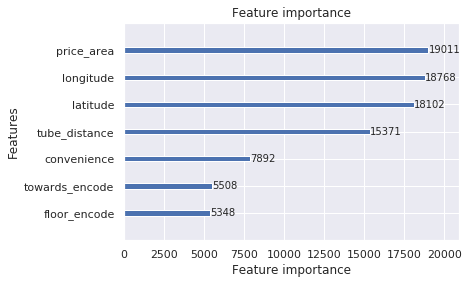

In [23]:
ax = lgb.plot_importance(gbm, max_num_features=7)
plt.show()

In [25]:
data['convenience'].describe()

count    1485.000000
mean       97.281152
std         3.269421
min        84.794705
25%        96.943655
50%        98.340495
75%        99.136810
max        99.826370
Name: convenience, dtype: float64

### 预测房价

In [26]:
predict_lgb=gbm.predict(data[col]) 

data['rent_room_lgb']=predict_lgb

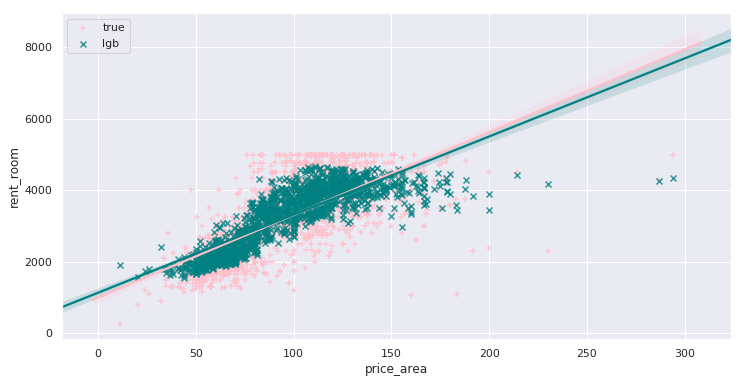

In [27]:
plt.figure(figsize=(12,6))
sns.regplot(data['price_area'],data['rent_room'],color='pink',label = 'true', marker = '+')
sns.regplot(data['price_area'],data['rent_room_lgb'],color='teal', label = 'lgb', marker = 'x')
plt.legend()
plt.xlabel('price_area')
plt.ylabel('rent_room')
plt.show()

In [28]:
predict=gbm.predict(test[col]) 

test['rent_room_pre']=predict

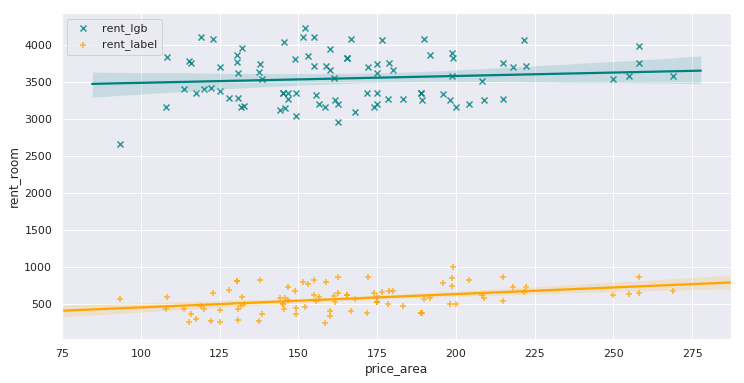

In [29]:
plt.figure(figsize=(12,6))
sns.regplot(test['price_area'],test['rent_room_pre'],color='teal', label = 'rent_lgb', marker = 'x')
sns.regplot(test['price_area'],test['rent_room'],color='orange',label = 'rent_label', marker = '+')
plt.legend()
plt.xlabel('price_area')
plt.ylabel('rent_room')
plt.show()

## 神经网络建立房价预测模型

### 不带embedding层的多层神经网络

In [30]:
col=['price_area', 'tube_distance','convenience', 'latitude', 'longitude']

X=data[col].values
y=data['rent_room'].values

X = X[:,0:5]
Y = y[:,]

In [31]:
# 随机拆分训练集与测试集

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3)
 
# 全连接神经网络
model = Sequential()
input = X.shape[1]
# 隐藏层256
model.add(Dense(256, input_shape=(input,)))
model.add(Activation('relu'))
#Dropout层用于防止过拟合
model.add(Dropout(0.2))

# 隐藏层128
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 隐藏层64
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 回归问题输出层不需要激活函数
model.add(Dense(1))
# 用 ADAM 优化算法以及优化的最小均方误差损失函数
model.compile(loss='mean_squared_error', optimizer=Adam())
# early stoppping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# 训练
history = model.fit(train_X, train_y, epochs=80, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[early_stopping])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1039 samples, validate on 446 samples
Epoch 1/80
 - 1s - loss: 4759443.6409 - val_loss: 1562234.4232
Epoch 2/80
 - 0s - loss: 1277275.8618 - val_loss: 763526.3142
Epoch 3/80
 - 0s - loss: 875510.3216 - val_loss: 699337.6312
Epoch 4/80
 - 0s - loss: 823007.4714 - val_loss: 663223.9254
Epoch 5/80
 - 0s - loss: 844972.3251 - val_loss: 645695.9204
Epoch 6/80
 - 0s - loss: 800320.6592 - val_loss: 654551.3491
Epoch 7/80
 - 0s - loss: 802517.7812 - val_loss: 622666.2656
Epoch 8/80
 - 0s - loss: 772039.2956 - val_loss: 613948.2571
Epoch 9/80
 - 0s - loss: 749462.4418 - val_loss: 612079.2979
Epoch 10/80
 - 0s - loss: 780433.9783 - val_loss: 617833.1717
Epoch 11/80
 - 0s - loss: 755089.6566 - val_loss: 603919.4608
Epoch 12/80
 - 0s - loss: 740076.1170 - va

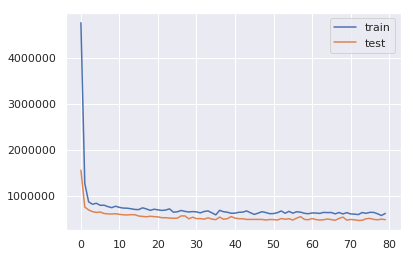

In [32]:
# loss曲线
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 699.465


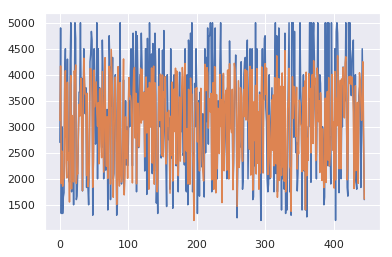

In [33]:
# 预测
yhat = model.predict(test_X)
# 预测y逆标准化
inv_yhat0 = concatenate((test_X, yhat), axis=1)
inv_yhat = inv_yhat0[:,-1]
# 原始y逆标准化
test_y = test_y.reshape((len(test_y), 1))
inv_y0 = concatenate((test_X,test_y), axis=1)
inv_y = inv_y0[:,-1]
# 计算 RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [34]:
predict_nn=model.predict(data[col]) 

data['rent_room_pre_nn']=predict_nn

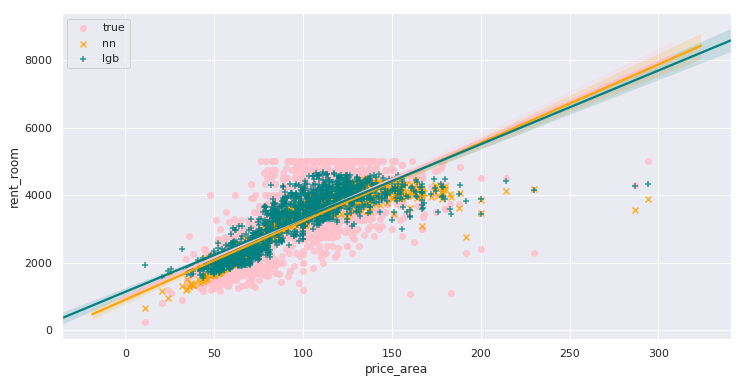

In [35]:
plt.figure(figsize=(12,6))
sns.regplot(data['price_area'],data['rent_room'],color='pink', label = 'true', marker = 'o')
sns.regplot(data['price_area'],data['rent_room_pre_nn'],color='orange',label = 'nn', marker = 'x')
sns.regplot(data['price_area'],data['rent_room_lgb'],color='teal',label = 'lgb',marker = '+')
plt.legend()
plt.xlabel('price_area')
plt.ylabel('rent_room')
plt.show()

### 带embedding层的多层神经网络

In [36]:
def build_embedding_network():
 
    inputs = []
    embeddings = []
    
    
    input_cate_feature_1 = Input(shape=(1,))
    embedding = Embedding(4, 2, input_length=1)(input_cate_feature_1)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_cate_feature_1)
    embeddings.append(embedding)
    
    input_cate_feature_2 = Input(shape=(1,))
    embedding = Embedding(39, 6, input_length=1)(input_cate_feature_2)
    embedding = Reshape(target_shape=(6,))(embedding)
    inputs.append(input_cate_feature_2)
    embeddings.append(embedding)
    
    input_numeric = Input(shape=(5,))
    embedding_numeric = Dense(256)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
 
    x = Concatenate()(embeddings)
   
    x = Dense(128, activation='relu')(x)
    x = Dropout(.15)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(.15)(x)
    
    output = Dense(1, activation='relu')(x)
    
    model = Model(inputs, output)
 
    model.compile(loss='mean_squared_error', optimizer=Adam())
    print(model.summary())
    
    return model

In [37]:
col=['floor_encode', 'towards_encode', 'price_area', 'tube_distance','convenience', 'latitude', 'longitude']
cate1=['floor_encode']
cate2=['towards_encode']
cont=['price_area', 'tube_distance','convenience', 'latitude', 'longitude']

X=data[col].values
y=data['rent_room'].values

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3)

# 调整train数据集
tr_cate_feature_1 = train_X[:,0:1]
tr_cate_feature_2 = train_X[:,1:2]
tr_contious_feature = train_X[:,2:7]

tr_X = []
tr_X.append(tr_cate_feature_1)
tr_X.append(tr_cate_feature_2)
tr_X.append(tr_contious_feature)

tr_label = train_y[:,]
tr_Y = []
tr_Y.append(tr_label)

# 调整test数据集
te_cate_feature_1 = test_X[:,0:1]
te_cate_feature_2 = test_X[:,1:2]
te_contious_feature = test_X[:,2:7]

te_X = []
te_X.append(te_cate_feature_1)
te_X.append(te_cate_feature_2)
te_X.append(te_contious_feature)

te_label = test_y[:,]
te_Y = []
te_Y.append(te_label)

In [38]:
import tensorflow as tf
import random as rn
 
#random seeds for stochastic parts of neural network 
np.random.seed(10)
from tensorflow import set_random_seed
set_random_seed(15)
 
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
embedding_nn = build_embedding_network()
history = embedding_nn.fit(tr_X, tr_Y, epochs=200, batch_size=20, validation_data=(te_X, te_Y), verbose=2, shuffle=False, callbacks=[early_stopping])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         8           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 6)         234         input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (I

Test RMSE: 788.722


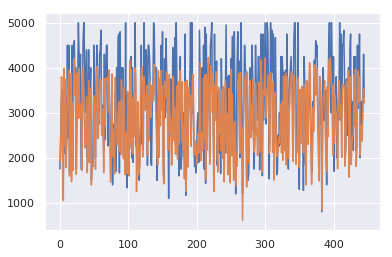

In [40]:
# 预测
yhat = embedding_nn.predict(te_X)
# 预测y逆标准化

inv_yhat0 = concatenate((test_X, yhat), axis=1)
inv_yhat = inv_yhat0[:,-1]
# 原始y逆标准化
test_y = test_y.reshape((len(test_y), 1))
inv_y0 = concatenate((test_X,test_y), axis=1)
inv_y = inv_y0[:,-1]
# 计算 RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [41]:
col=['floor_encode', 'towards_encode', 'price_area', 'tube_distance','convenience', 'latitude', 'longitude']
cate1=['floor_encode']
cate2=['towards_encode']
cont=['price_area', 'tube_distance','convenience', 'latitude', 'longitude']

cate_feature_1 = data[cate1].values
cate_feature_2 = data[cate2].values
contious_feature = data[cont].values

TX = []
TX.append(cate_feature_1)
TX.append(cate_feature_2)
TX.append(contious_feature)

TY = data['rent_room'].values

preds_emnn = embedding_nn.predict(TX)[:,0]
data['rent_room_emnn'] = preds_emnn

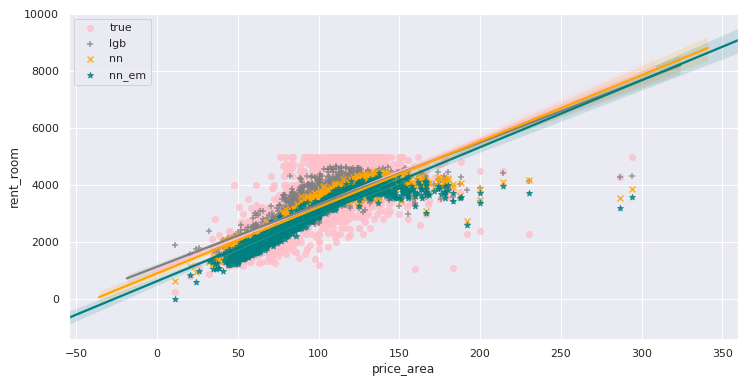

In [42]:
plt.figure(figsize=(12,6))
sns.regplot(data['price_area'],data['rent_room'],color='pink', label = 'true', marker = 'o')
sns.regplot(data['price_area'],data['rent_room_lgb'],color='gray',label = 'lgb',marker = '+')
sns.regplot(data['price_area'],data['rent_room_pre_nn'],color='orange',label = 'nn', marker = 'x')
sns.regplot(data['price_area'],data['rent_room_emnn'],color='teal',label = 'nn_em',marker = '*')
plt.legend()
plt.xlabel('price_area')
plt.ylabel('rent_room')
plt.show()